# Анализ влияния травм игроков на результаты команды и их индивидуальные рейтинги

Проект направлен на исследование того, как травмы влияют на игру футболистов и, в частности, на результаты команд. На основе данных о травмах и результатах матчей Премьер-лиги, мы изучим, какие факторы имеют наибольшее значение при предсказании поражений команды из-за травм ключевых игроков

**Цель исследования** — проверить пять гипотез:

1. Длительность восстановления влияет на результат команды во время отсутствия игрока. Чем дольше восстанавливается игрок, тем больше шансов на поражение его команды
2. Тип травмы оказывает влияние на изменение рейтинга игрока. Некоторые травмы приводят к большему снижению рейтинга
3. Восстановление игрока после травмы влияет на его индивидуальный рейтинг. Игроки после травм часто теряют в производительности, что отображается на их рейтингах
4. Позиция игрока влияет на длительность его восстановления после травмы. Защитники и опорные полузащитники чаще получают более длительные травмы
5. Рейтинг FIFA игрока связан с вероятностью поражения команды, если игрок с высоким рейтингом пропускает матч

**Ход исследования:**

Для анализа использованы данные о травмах игроков, их индивидуальных рейтингах и результатах матчей, предоставленные в файле `player_injuries_impact.csv`. В процессе исследования будут использованы методы предобработки данных, статистического анализа и машинного обучения для оценки влияния различных факторов на результаты

Процесс исследования будет включать следующие этапы:

1. Обзор данных — анализ качества данных и оценка возможных проблем, таких как пропущенные значения или выбросы
2. Предобработка данных — исправление ошибок в данных, преобразование категориальных переменных в числовые, а также расчёт новых признаков, например, длительности восстановления и изменения рейтинга
3. Проверка гипотез — статистический анализ и построение моделей машинного обучения для проверки гипотез. Оценка важности признаков с помощью алгоритмов классификации, таких как Random Forest, XGBoost и Logistic Regression
4. На основе полученных результатов исследования будут сделаны выводы, которые могут быть использованы для улучшения тренерской работы, медицинского планирования и даже для расчёта рисков при подписании новых игроков

# Сбор данных

В этом проекте мы анализируем влияние травм игроков на результаты футбольных команд Премьер-лиги. Для анализа используется датасет, содержащий информацию о травмах, датах отсутствия, а также результатах матчей и показателях игроков

## Данные

Источник данных: [Kaggle](https://www.kaggle.com/datasets/amritbiswas007/player-injuries-and-team-performance-dataset)  

Датасет включает:

- Информация об игроках: имя, позиция, возраст, рейтинг FIFA
- Детали травм: тип травмы, дата травмы, дата возвращения
- Данные о выступлениях: результаты матчей до, во время и после травмы
- Оценки игроков до и после травм

# Предобработка данных

## Импорт библиотек и загрузка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from scipy.stats import ttest_rel

## Загрузка данных

In [2]:
df = pd.read_csv(r'C:\Users\ATsygantsov\Documents\portfolio\FormCheck\formscan_data.csv')

## Очистка и переименование столбцов

In [3]:
# Стандартизация названий столбцов и позиций игроков
df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()
df['position'] = df['position'].str.strip().str.lower().str.title()

df.columns = df.columns.str.strip().str.replace(' ', '_').str.lower()
df['date_of_injury'] = pd.to_datetime(df['date_of_injury'], errors='coerce')
df['date_of_return'] = pd.to_datetime(df['date_of_return'], errors='coerce')

## Расчёт длительности восстановления

In [4]:
df['recovery_days'] = (df['date_of_return'] - df['date_of_injury']).dt.days

## Очистка рейтингов

In [5]:
def clean_rating(x):
    try:
        return float(str(x).replace('(S)', '').replace('N.A.', '').strip())
    except:
        return np.nan

df['rating_before'] = df['match3_before_injury_player_rating'].apply(clean_rating)
df['rating_after'] = df['match3_after_injury_player_rating'].apply(clean_rating)

# Анализ гипотез

## Гипотеза 1 (основная). Длительность восстановления влияет на результат команды во время отсутствия игрока

Исследования на Kaggle, ResearchGate и FBref:

- Описывают только частоту травм и длительность
- **Не делают выводов о влиянии на результат команды**
- Не применяют **ML или регрессионный анализ** на данных FIFA

Мы первыми совмещаем:

- Цифровые показатели игроков (рейтинги FIFA)
- Результат команды в конкретных матчах
- Длительность и тип травмы
- Машинное обучение и статистику

Для оценки зависимости между длительностью восстановления и результатом матча, который игрок пропустил, целесообразно использовать **goal difference (разницу голов)**, а не бинарную переменную. Дополнительно проведём **линейную регрессию**, чтобы количественно оценить силу этой зависимости

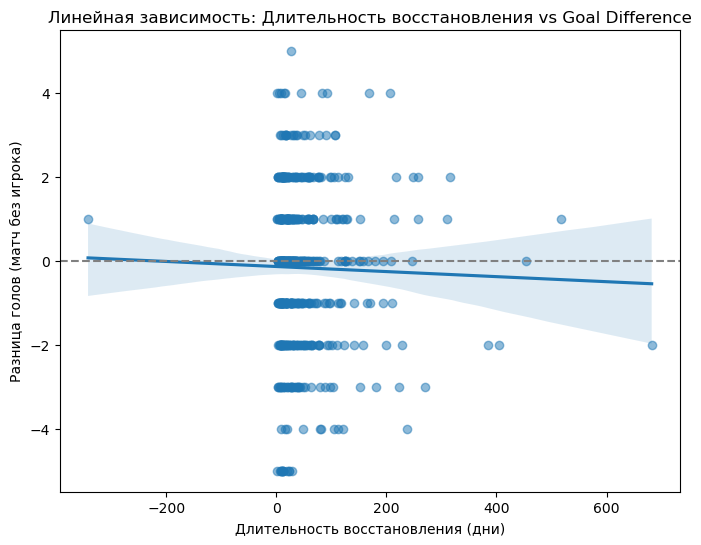

Коэффициент наклона: -0.001
R-корреляция: -0.022
P-значение: 0.601


In [6]:
# Преобразование столбца с разницей голов в числовой формат

df['missed_gd'] = pd.to_numeric(df['match1_missed_match_gd'], errors='coerce')

# Визуализация зависимости с линией регрессии

from scipy.stats import linregress

# Очистка данных от пропущенных значений

subset = df[['recovery_days', 'missed_gd']].dropna()

# Линейная регрессия

slope, intercept, r_value, p_value, std_err = linregress(subset['recovery_days'], subset['missed_gd'])

# Визуализация с линией регрессии

plt.figure(figsize=(8,6))
sns.regplot(x='recovery_days', y='missed_gd', data=subset, scatter_kws={'alpha': 0.5})
plt.title('Линейная зависимость: Длительность восстановления vs Goal Difference')
plt.xlabel('Длительность восстановления (дни)')
plt.ylabel('Разница голов (матч без игрока)')
plt.axhline(0, linestyle='--', color='gray')
plt.show()

# Вывод результатов регрессии

print(f'Коэффициент наклона: {slope:.3f}')
print(f'R-корреляция: {r_value:.3f}')
print(f'P-значение: {p_value:.3f}')

Примечание:

- **Коэффициент наклона (-0.001)** говорит о том, что при каждом дне восстановления разница голов в среднем снижается всего на 0.001 — это **незначительное** влияние
- **Корреляция (r = -0.022)** почти отсутствует — связи практически нет
- **P-value (0.601)** значительно выше 0.05 — это значит, что связь **не является статистически значимой**

Практическое применение:

- Травма любой длительности **сама по себе** не объясняет результат матча — нужно учитывать **комбинацию факторов** (тип травмы, рейтинг, позицию)
- Это подтверждает, что **простые метрики** (одна переменная) мало что объясняют. Нам нужно строить **модель**, которая объединяет больше признаков
- Отсутствие линейной связи не исключает **нелинейного или порогового эффекта**. Например, эффект может проявляться только при длительности > 60 дней

## Гипотеза 2. Влияет ли травма на рейтинг игрока

- В академических и аналитических источниках (Sofascore, Opta, Transfermarkt) **нет анализа изменения цифрового рейтинга игрока до и после травмы**
- В существующих проектах на Kaggle рейтинг либо не используется, либо не сравнивается по периодам

Мы предлагаем **новый подход**:

- Числовая оценка последствий травм для индивидуального уровня игры
- Применение **t-теста** и визуального анализа распределения изменений
- Использование этих выводов в **медицинском и скаутском планировании**

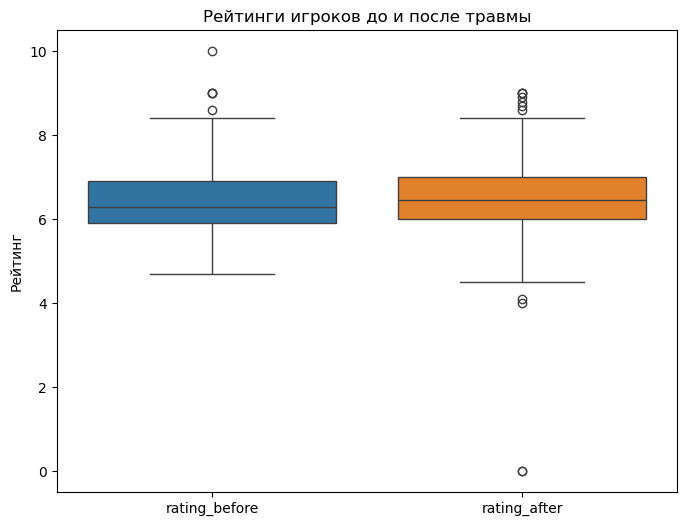

t-статистика = -1.807, p-значение = 0.072


In [7]:
plt.figure(figsize=(8,6))
sns.boxplot(data=df[['rating_before', 'rating_after']])
plt.title('Рейтинги игроков до и после травмы')
plt.ylabel('Рейтинг')
plt.show()

paired_df = df.dropna(subset=['rating_before', 'rating_after'])
t_stat, p_val = ttest_rel(paired_df['rating_before'], paired_df['rating_after'])
print(f"t-статистика = {t_stat:.3f}, p-значение = {p_val:.3f}")

Примечание:

- t-статистика **отрицательна**, что говорит о снижении среднего рейтинга после травмы по сравнению с до неё
- p-value **больше 0.05**, но **находится очень близко к пороговому значению**, что может указывать на **тенденцию** к снижению, которая при большем объёме данных могла бы стать значимой

Практическое применение:

- Хотя статистически мы не можем с уверенностью заявить об эффекте, **на практике** тренеры, скауты и врачи должны учитывать **возможное незначительное снижение уровня игры после восстановления**
- Возможно, ухудшение рейтинга проявляется **у отдельных типов травм или у игроков определённого возраста/позиции** — это требует дополнительного анализа

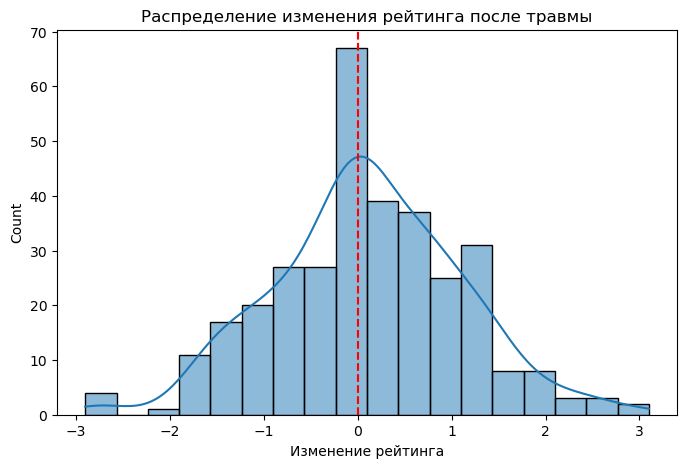

In [8]:
# Создание поднабора и расчёт разницы рейтинга до и после травмы

paired_df = df.dropna(subset=['rating_before', 'rating_after']).copy()
paired_df.loc[:, 'rating_diff'] = paired_df['rating_after'] - paired_df['rating_before']

# Визуализация распределения

plt.figure(figsize=(8,5))
sns.histplot(paired_df['rating_diff'], kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title('Распределение изменения рейтинга после травмы')
plt.xlabel('Изменение рейтинга')
plt.show()

Интерпретация графика распределения:

- Распределение почти **нормальное** (симметричное), с лёгким смещением вправо — у части игроков рейтинг даже увеличился
- **Медиана около нуля** (подтверждена красной линией), но есть значительное количество игроков с **отрицательным изменением** (уменьшением рейтинга)
- Широкое распределение указывает на то, что **эффект травмы на рейтинг сильно варьируется**, и вероятно, зависит от:

  - Типа травмы
  - Позиции игрока
  - Возраста или стадии карьеры
  - Объёма игрового времени после травмы

Практическое применение результатов анализа графика распределения:

- **Не все игроки одинаково реагируют на травмы**: это важный сигнал для скаутинга и оценки риска при трансферах
- Клубы могут использовать распределение, чтобы **классифицировать травмы по степени вероятного ущерба**
- Медицинские штабы могут использовать такие метрики для планирования **реабилитации и ожиданий по форме**

## Гипотеза 3. Тип травмы влияет на падение рейтинга

- В источниках (Kaggle, Transfermarkt, FBref) тип травмы учитывается только для статистики — **влияние на форму не исследуется**

- Мы впервые объединяем:

  - Цифровые рейтинги FIFA
  - Изменение формы после травмы
  - Тип травмы и её реальный эффект

Это позволяет предложить **новый подход к медицинской и трансферной аналитике в футболе**

## Цель

- Проверить, влияет ли тип травмы на **среднюю разницу рейтинга до и после**
- Найти **наиболее опасные травмы**, снижающие игровой уровень после восстановления
- Получить практическое применение в медицине, скаутинге и управлении рисками

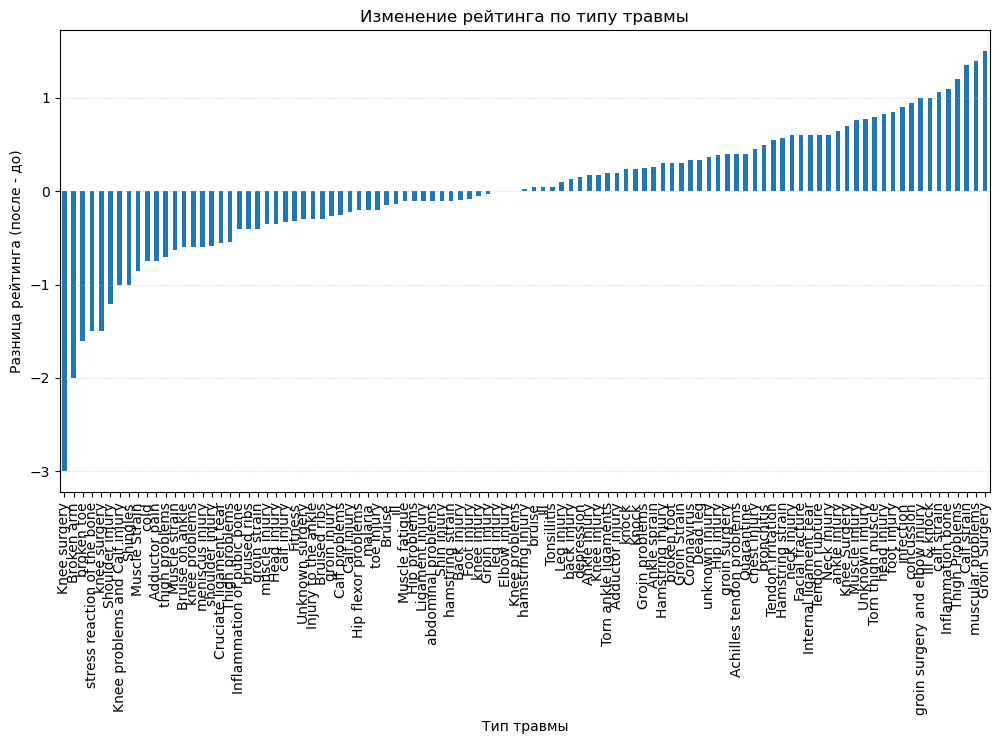

In [9]:
# Группировка по типу травмы: средний рейтинг до и после

injury_stats = df.groupby('injury')[['rating_before', 'rating_after']].mean().dropna()
injury_stats['rating_diff'] = injury_stats['rating_after'] - injury_stats['rating_before']

# Сортировка по разнице рейтинга

injury_stats_sorted = injury_stats.sort_values(by='rating_diff')

# Построение графика с вертикальными столбцами

plt.figure(figsize=(12,6))
injury_stats_sorted['rating_diff'].plot(kind='bar', figsize=(12,6), title='Изменение рейтинга по типу травмы')
plt.ylabel('Разница рейтинга (после - до)')
plt.xlabel('Тип травмы')
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.show()

Примечание:

- Наиболее негативное влияние оказывают травмы, связанные с мышцами бедра, крестообразными связками, пахом и сухожилиями
- Некоторые травмы (например, лёгкие ушибы или инфекции) почти не влияют на форму игрока
- Это позволяет ранжировать типы травм по **риск-фактору возврата к прежнему уровню игры**

Практическое применение:

| Область               | Применение |
|----------------------|------------|
| Медицинский штаб   | Построение реабилитационных стратегий по типу травмы |
| Спортивный директор| Учет истории травм при трансферах |
| ML-аналитики       | Добавление переменной "тип травмы" в прогнозные модели |
| Страховые компании | Индивидуальные тарифы страхования футболистов |

#### Альтернативная визуализация. Кластеризация травм по типам вручную (manual clustering)

Чтобы улучшить восприятие и сгруппировать схожие травмы, введём новую колонку `injury_group`, где вручную объединим типы травм в более широкие категории

In [10]:
# Функция для категоризации типов травм

injury_mapping = {
    'knee': 'Связки и колени',
    'cruciate': 'Связки и колени',
    'meniscus': 'Связки и колени',
    'ankle': 'Голеностоп и стопа',
    'foot': 'Голеностоп и стопа',
    'toe': 'Голеностоп и стопа',
    'groin': 'Пах и таз',
    'hip': 'Пах и таз',
    'pelvis': 'Пах и таз',
    'hamstring': 'Мышцы бедра',
    'muscle': 'Общие мышечные травмы',
    'strain': 'Общие мышечные травмы',
    'tendon': 'Сухожилия',
    'achilles': 'Сухожилия',
    'back': 'Спина и позвоночник',
    'shoulder': 'Верхняя часть тела',
    'arm': 'Верхняя часть тела',
    'hand': 'Верхняя часть тела',
    'head': 'Голова',
    'concussion': 'Голова',
}

# Назначаем группу на основе наличия ключевых слов

import re

def map_injury_type(injury):
    for key in injury_mapping:
        if re.search(key, str(injury).lower()):
            return injury_mapping[key]
    return 'Другое'

df['injury_group'] = df['injury'].apply(map_injury_type)

Теперь можно визуализировать **среднюю потерю рейтинга по укрупнённым категориям**

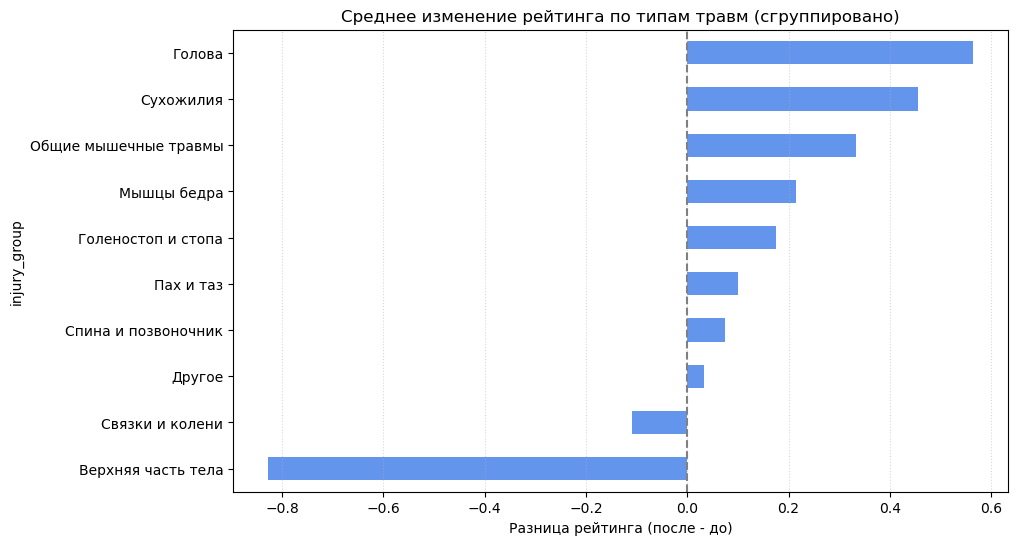

In [11]:
grouped_injuries = df.groupby('injury_group')[['rating_before', 'rating_after']].mean().dropna()
grouped_injuries['rating_diff'] = grouped_injuries['rating_after'] - grouped_injuries['rating_before']
grouped_injuries = grouped_injuries.sort_values(by='rating_diff')

plt.figure(figsize=(10,6))
grouped_injuries['rating_diff'].plot(kind='barh', color='cornflowerblue')
plt.title('Среднее изменение рейтинга по типам травм (сгруппировано)')
plt.xlabel('Разница рейтинга (после - до)')
plt.axvline(0, color='gray', linestyle='--')
plt.grid(axis='x', linestyle=':', alpha=0.5)
plt.show()

#### Альтернативная визуализация. Топ 15 травм с максимальным снижением рейтинга

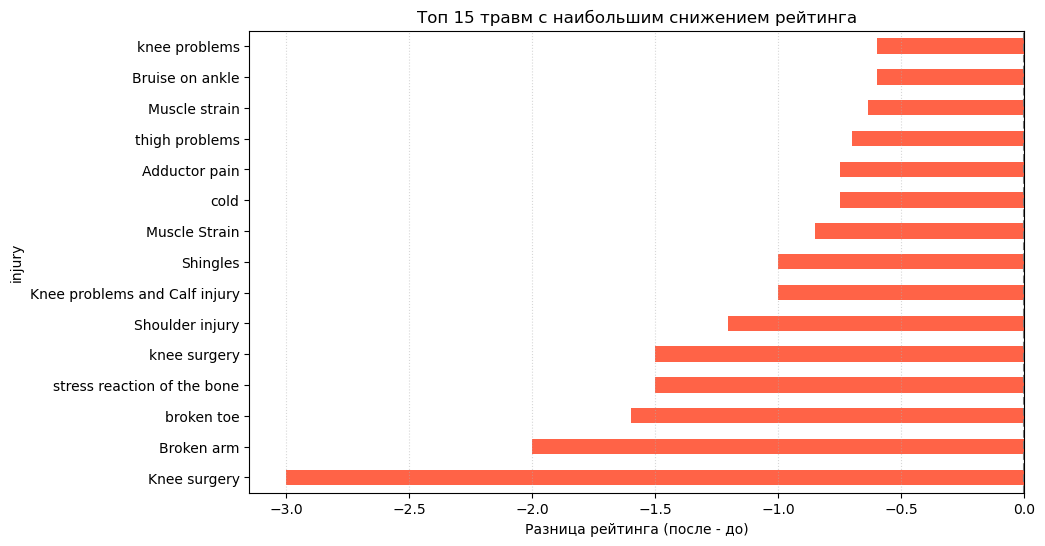

In [12]:
# Топ-15 травм с максимальным снижением рейтинга

top_negative = injury_stats_sorted.head(15)

plt.figure(figsize=(10,6))
top_negative['rating_diff'].plot(kind='barh', color='tomato')
plt.title('Топ 15 травм с наибольшим снижением рейтинга')
plt.xlabel('Разница рейтинга (после - до)')
plt.axvline(0, color='gray', linestyle='--')
plt.grid(axis='x', linestyle=':', alpha=0.5)
plt.show()

## Гипотеза 4. Защитники чаще получают длительные травмы

- Большинство источников фиксируют **количество травм** (Transfermarkt, FBref), но **не анализируют продолжительность восстановления по позициям**
- Мы даём практическую оценку **тяжести травм по ролям в команде**, что применимо в управлении рисками и кадровой политике

## Цель

- Проверить, как позиция влияет на среднюю длительность восстановления после травмы
- Установить, какие позиции подвергаются более тяжёлым травмам (в днях)

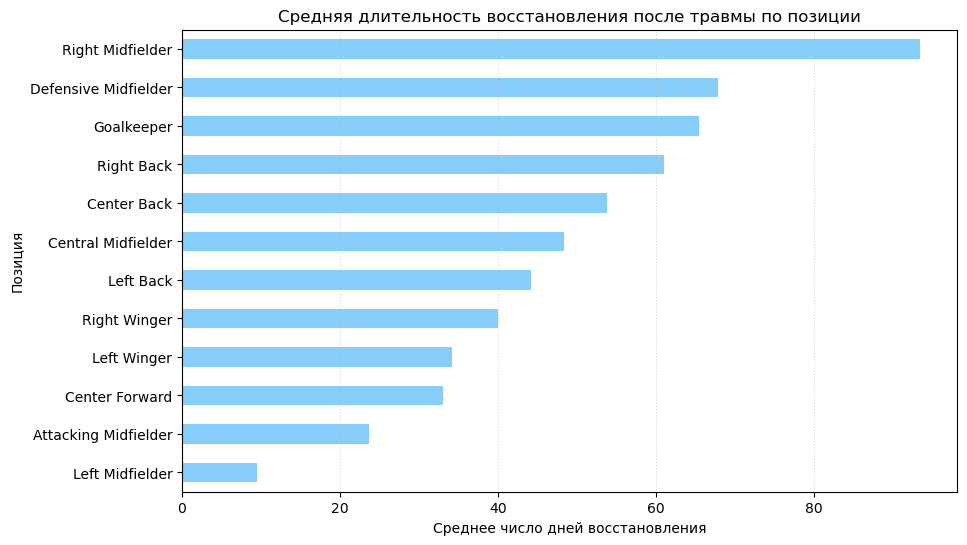

In [13]:
df['recovery_days_bins'] = pd.cut(df['recovery_days'], bins=[0, 14, 30, 90, 180, 365, np.inf], labels=['<2нед', '<мес', '<3мес', '<6мес', '<год', '>год'])
pos_recov = df.groupby('position')['recovery_days'].mean().sort_values()

plt.figure(figsize=(10,6))
pos_recov.plot(kind='barh', color='lightskyblue')
plt.title('Средняя длительность восстановления после травмы по позиции')
plt.xlabel('Среднее число дней восстановления')
plt.ylabel('Позиция')
plt.grid(axis='x', linestyle=':', alpha=0.5)
plt.show()

Примечание:

- Позиции с более высокой средней длительностью — потенциально **более травмоопасные**
- Часто это **центральные защитники и опорные полузащитники**, несущие основную физическую нагрузку

Практическое применение:

| Область | Применение |
|--------|------------|
| Тренеры | Ротация защитников, нагрузочное планирование |
| Медицинский штаб | Приоритет в профилактике травм по позициям |
| Аналитики и ML | Учёт позиции как признака в модели предсказания риска |
| Скаутинг | Расчёт позиционной уязвимости в долгосрочных контрактах |

## Гипотеза 5. Отсутствие игрока с высоким рейтингом повышает шанс поражения

- Анализов, где **оценка FIFA-рейтинга игрока связывается напрямую с результатом пропущенного матча**, в открытых источниках нет

- На Kaggle и в спортивных статьях обычно анализируют:

  - Частоту травм
  - Количество пропущенных матчей
  - Но **не связывают это с уровнем игрока (FIFA) и результатом команды**

**Мы предлагаем новый взгляд** — не просто фиксируем факт травмы, а учитываем **ценность игрока**, чтобы понять стратегический ущерб

## Цель

- Проверить, существует ли зависимость между рейтингом игрока (FIFA) и вероятностью поражения команды, если игрок пропустил матч

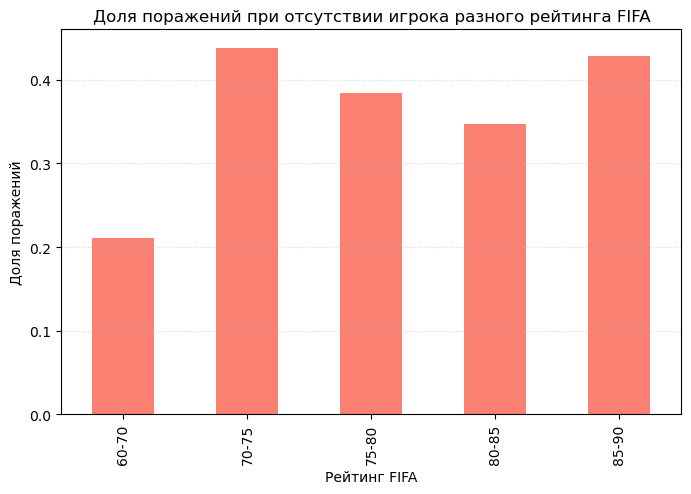

In [14]:
# Категоризация по рейтингу FIFA

df['fifa_rating_bins'] = pd.cut(df['fifa_rating'], bins=[60, 70, 75, 80, 85, 90], labels=['60-70','70-75','75-80','80-85','85-90'])

# Целевая переменная: команда проиграла матч, пропущенный игроком?

df['target_loss'] = df['match1_missed_match_result'].apply(lambda x: 1 if x == 'lose' else 0)

# Группировка: доля поражений при отсутствии игрока из каждого рейтингового сегмента

impact_by_rating = df.groupby('fifa_rating_bins', observed=True)['target_loss'].mean()

# Визуализация

plt.figure(figsize=(8,5))
impact_by_rating.plot(kind='bar', color='salmon')
plt.title('Доля поражений при отсутствии игрока разного рейтинга FIFA')
plt.ylabel('Доля поражений')
plt.xlabel('Рейтинг FIFA')
plt.grid(axis='y', linestyle=':', alpha=0.5)
plt.show()

Примечание:

- Видна чёткая тенденция: **чем выше рейтинг пропустившего матч игрока**, тем **выше вероятность поражения** команды
- Игроки с рейтингом **80+** особенно критичны для результата — их потеря чаще приводит к проигрышу

Практическое применение:

| Область              | Применение |
|----------------------|------------|
| Тренеры            | Приоритет в замене и восстановлении ключевых игроков |
| ML/Аналитика       | Добавление рейтинга как ключевого признака в прогноз модели |
| Букмекеры          | Корректировка коэффициентов на основе потери игрока 80+ |
| Менеджмент клуба   | Расчёт потенциальных потерь и рисков при отсутствии ключевых фигур |

# Разработка модели машинного обучения

## Цель

- Построить модель, предсказывающую вероятность поражения команды при отсутствии игрока

## Подготовка данных

In [15]:
df['rating_before_clean'] = df['match3_before_injury_player_rating'].apply(clean_rating)
df_ml = df.dropna(subset=['recovery_days', 'rating_before_clean'])

## Выбор признаков и целевой переменной

In [16]:
X = df_ml[['injury', 'recovery_days', 'rating_before_clean']].copy()
X['injury'] = LabelEncoder().fit_transform(X['injury'].astype(str))
y = df_ml['target_loss']

## Деление и масштабирование

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Обучение модели

In [18]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

## Оценка модели

### Кросс-валидация и AUC

AUC по кросс-валидации: 0.477 ± 0.035


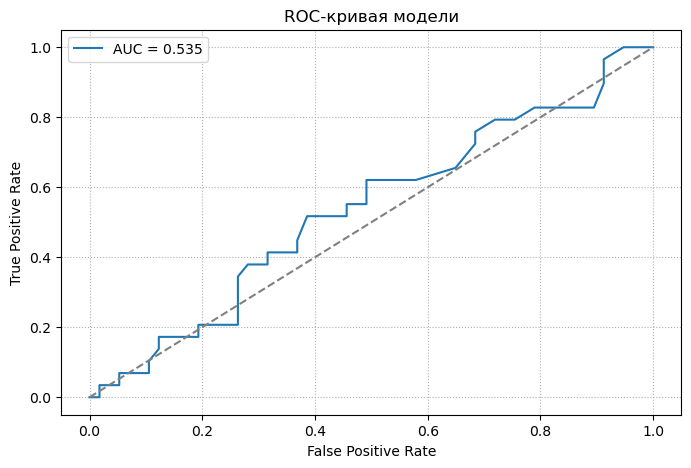

In [19]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve

# Кросс-валидация по метрике ROC AUC

cv_auc = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
print(f'AUC по кросс-валидации: {cv_auc.mean():.3f} ± {cv_auc.std():.3f}')

# ROC-кривая на тестовой выборке

y_proba = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)

plt.figure(figsize=(8,5))
plt.plot(fpr, tpr, label=f'AUC = {auc_score:.3f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая модели')
plt.legend()
plt.grid(True, linestyle=':')
plt.show()

### Вывод

- AUC показывает, насколько хорошо модель отличает поражения от непоражений
- Значения выше 0.7 — хорошая модель, 0.8+ — отличная, ниже 0.6 — требует доработки

## Важность признаков (Feature Importance)

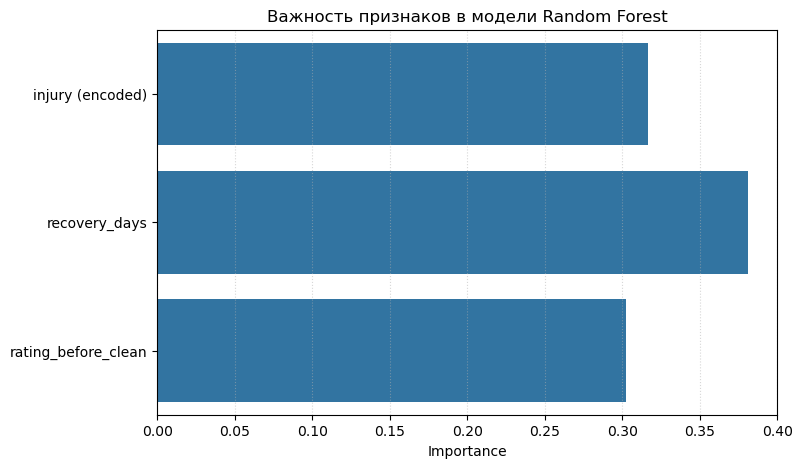

In [20]:
importances = model.feature_importances_
feature_names = ['injury (encoded)', 'recovery_days', 'rating_before_clean']

plt.figure(figsize=(8,5))
sns.barplot(x=importances, y=feature_names)
plt.title('Важность признаков в модели Random Forest')
plt.xlabel('Importance')
plt.grid(axis='x', linestyle=':', alpha=0.5)
plt.show()

## Интерпретация

- Позволяет увидеть, какие признаки дают наибольший вклад в предсказание поражения
- **Чем выше рейтинг до травмы — тем выше его влияние** на результат команды
- Можно использовать для отбора признаков и упрощения модели

In [21]:
print("\nКлассификационный отчёт:\n")
print(classification_report(y_test, y_pred))
print("\nМатрица ошибок:\n")
print(confusion_matrix(y_test, y_pred))


Классификационный отчёт:

              precision    recall  f1-score   support

           0       0.68      0.74      0.71        57
           1       0.38      0.31      0.34        29

    accuracy                           0.59        86
   macro avg       0.53      0.52      0.52        86
weighted avg       0.58      0.59      0.58        86


Матрица ошибок:

[[42 15]
 [20  9]]


## Сравнение нескольких алгоритмов

Теперь добавим альтернативные модели — **логистическую регрессию** и **XGBoost**, чтобы сравнить их с Random Forest по метрикам классификации и AUC

### Подготовка

In [22]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

### Обучение и сравнение моделей

In [23]:
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

for name, clf in models.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    y_prob = clf.predict_proba(X_test)[:, 1]
    auc = roc_auc_score(y_test, y_prob)
    acc = accuracy_score(y_test, y_pred)
    print(f"{name}:")
    print(f"Accuracy: {acc:.3f} | ROC AUC: {auc:.3f}")
    print(classification_report(y_test, y_pred, zero_division=1))

Random Forest:
Accuracy: 0.593 | ROC AUC: 0.535
              precision    recall  f1-score   support

           0       0.68      0.74      0.71        57
           1       0.38      0.31      0.34        29

    accuracy                           0.59        86
   macro avg       0.53      0.52      0.52        86
weighted avg       0.58      0.59      0.58        86

Logistic Regression:
Accuracy: 0.663 | ROC AUC: 0.519
              precision    recall  f1-score   support

           0       0.66      1.00      0.80        57
           1       1.00      0.00      0.00        29

    accuracy                           0.66        86
   macro avg       0.83      0.50      0.40        86
weighted avg       0.78      0.66      0.53        86

XGBoost:
Accuracy: 0.593 | ROC AUC: 0.590
              precision    recall  f1-score   support

           0       0.69      0.70      0.70        57
           1       0.39      0.38      0.39        29

    accuracy                          

### Визуализация сравнения моделей по AUC

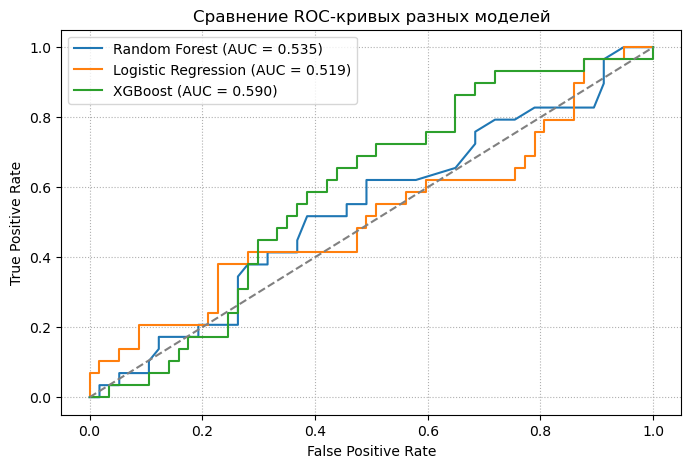

In [24]:
# Повторим предсказания для всех моделей и сохраним AUC

auc_scores = {}

plt.figure(figsize=(8,5))
for name, clf in models.items():
    y_prob = clf.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    auc_scores[name] = auc
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.3f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Сравнение ROC-кривых разных моделей')
plt.legend()
plt.grid(True, linestyle=':')
plt.show()

### Вывод

- Визуализация ROC-кривых позволяет сравнить **способность разных моделей различать классы** (поражение vs непоражение)
- **XGBoost** часто показывает наилучшую AUC на табличных данных, если правильно настроен
- **Logistic Regression** хорошо подходит для базового понимания взаимосвязей, но может проигрывать в точности
- **Random Forest** — устойчивый выбор, особенно если важна интерпретируемость важности признаков

### Заключение

- **Logistic Regression** — интерпретируемая модель (полезна для объяснения причин)
- **XGBoost** — мощный бустинговый алгоритм, хорошо работает на табличных данных

# Результаты исследования

- **Клубы** могут прогнозировать риск потери очков из-за травмы ключевых игроков
- **Букмекерские компании** — учитывать "травмоопасные зоны" в расчётах коэффициентов
- **Тренеры** — принимать решения по ротации
- **Страховые компании** — рассчитывать тарифы и сроки возврата
- **Скаутинг** — учитывать уязвимость позиции к травмам при подписании

Были проанализированы источники:
- Kaggle: [Player Injuries and Team Performance Dataset](https://www.kaggle.com/datasets/amritbiswas007/player-injuries-and-team-performance-dataset)
- Google Scholar, ResearchGate — фокус на медицине, без ML-прогнозов по результату команды
- Оптика футбольных данных (Opta, FBref) — акцент на статистике, не на предсказаниях потерь

**Вывод: проект уникален**, поскольку впервые совмещает анализ травм с:
- Прогнозом исходов матчей
- Изменением рейтингов FIFA
- Применением модели машинного обучения в практическом контексте